In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random

In [3]:
G = nx.read_weighted_edgelist("Contact-diaries-network_data_2013.csv", nodetype=int)

In [4]:
color_map=['blue' for number in range(len(G.nodes()))]

In [5]:
color_map[3] = 'red'

In [6]:
opt = { 'node_color': color_map,
        'node_size': 50,
        'width': 1,
        'with_labels': False,
        'font_weight': 'bold'}

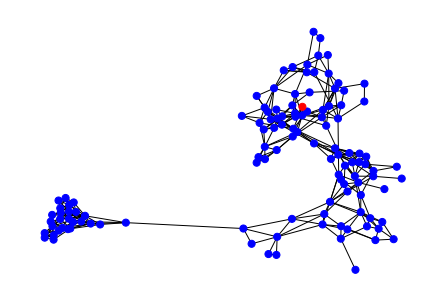

In [7]:
nx.draw(G, **opt)

In [11]:
def process_recovery(event, H, times, S, I, R): 
    #events are (0: time, 1: node, 2: type)

    H.nodes[event[1]]['status'] = 'recovered'
    times.append(event[0])
    S.append(S[-1])
    I.append(I[-1]-1)
    R.append(R[-1]+1)


In [12]:
def process_transmission(event, H, times, S, I, R, list_of_events, beta, gamma, Tmax): 
    
    #beta contagion rate or infection rate or transmission rate
    #gamma recovery rate
    #beta_fm rate or infection rate of people that use facemask, is less than beta.
    
    #events are (0: time, 1: node, 2: type)
    if H.nodes[event[1]]['status'] == 'susceptible':

        H.nodes[event[1]]['status'] = 'infected'

        times.append(event[0])
        S.append(S[-1]-1)
        I.append(I[-1]+1)
        R.append(R[-1])
        
        

        rec_time = event[0] + random.expovariate(gamma)

        if rec_time < Tmax:
            new_event = (rec_time, event[1], 'recovery')
            list_of_events.append(new_event)
            list_of_events.sort()

        for target in H.neighbors(event[1]):
            if H.nodes[target]['status'] == 'susceptible':
                inf_time = event[0] + random.expovariate(beta)
                
                if inf_time < min(rec_time, H.nodes[target]['pred_inf_time'], Tmax):
                    new_event = (inf_time, target, 'transmit')
                    list_of_events.append(new_event)
                    list_of_events.sort()
                    H.nodes[target]['pred_inf_time'] = inf_time            

In [13]:
def epidemic(H,beta,gamma,Tmax,k):
    if(nx.is_connected(H)==False):
        raise ValueError("Graph H must be connected")
    
    list_of_events = []
    times, S, I, R = [0], [len(H.nodes) - k], [0], [k]
           
    
    rank = random.sample(H.nodes,k)
    
    for u in H.nodes:
        if u in rank:
            H.nodes[u]['status']='recovered'
        else:
            H.nodes[u]['status'] = 'susceptible'
            H.nodes[u]['pred_inf_time'] = np.inf
    
    
   
    u = np.random.choice([i for i in H.nodes if i not in rank], size=1)[0]

    H.nodes[u]['pred_inf_time'] = 0

    #events are (time, node, type)
    event = (0, u, 'transmit')

    list_of_events.append(event)
    list_of_events.sort()
    
    while(len(list_of_events) > 0):
        event = list_of_events.pop(0)
    
        if event[2] == 'transmit':
            process_transmission(event,H, times, S, I, R, list_of_events, beta, gamma, Tmax)
        else:
            process_recovery(event,H, times, S, I, R)
    
    network_data = np.column_stack((times, S, I, R))
    return(network_data)

In [14]:
for k in (0,10,20,30,40,50,60,70,80,90,100,110,119):
    l =[]
    for i in range(5000):
        l.append(epidemic(G, 1.5, 1, 50, k)[-1][-1]-k)
    arr = np.array(l)
    txt = 'exp_' + format(k) + '.csv'
    np.savetxt(txt,arr,delimiter=",")